<a href="https://colab.research.google.com/github/alepenaa94/TP1_Real_or_Not/blob/master/TP1_Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

## Análisis realizado
- [Tratamiento de datos](#link_1)
- [Análisis del campo keyword](#link_2)
- [Análisis del campo location](#link_3)
- [Análisis de la cantidad de palabras de los tweets](#link_4)
- [Análisis de la longitud de los tweets](#link_5)
- [Covarianza y Correlación](#link_6)
- [Análisis de menciones](#link_7)
- [Análisis de "tweets expresivos"](#link_8)
- [Análisis de registros en donde el text no contenga la keyword](#link_9)
- [Análisis de hashtags](#link_10)
- [Análisis de tweets terroristas](#link_11)
- [Análisis de links](#link_12)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
train_df = pd.read_csv('./Data/train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


Para dar un primer vistazo a la información con la que vamos trabajar, veamos rápidamente cómo está distribuída la cantidad de tweets según si son verdaderos o falsos.

Text(0, 0.5, 'Cantidad de tweets')

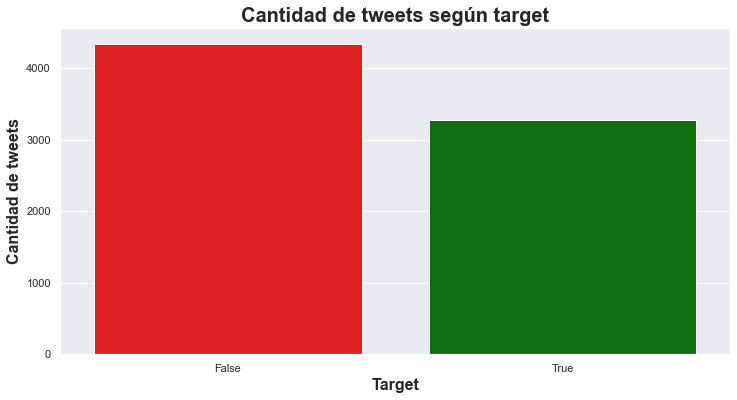

In [4]:
plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = train_df,palette=['red','green']);

plt.title('Cantidad de tweets según target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

## Tratamiento de datos<a id='link_1'></a>

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null uint16
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null bool
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas **"keyword"** y **"location"** poseen algunos valores nulos, vamos a analizar cada caso particular para determinar como vamos a proceder con los análisis.

## Análisis del campo keyword<a id='link_2'></a>

In [6]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

El campo **keyword** tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para los análisis vamos a considerar descartar los registros nulos.

Veamos que tipo de valores contiene este campo.

In [7]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
train_df.loc[~train_df['keyword'].isnull() & train_df['keyword'].str.contains('%20')]['keyword'].value_counts()

body%20bags              41
oil%20spill              38
burning%20buildings      37
nuclear%20reactor        36
cliff%20fall             36
dust%20storm             36
suicide%20bomb           35
emergency%20plan         35
buildings%20burning      35
airplane%20accident      35
structural%20failure     35
bridge%20collapse        35
nuclear%20disaster       34
natural%20disaster       34
loud%20bang              34
heat%20wave              34
mass%20murder            33
blew%20up                33
emergency%20services     33
violent%20storm          33
body%20bag               33
buildings%20on%20fire    33
fire%20truck             33
body%20bagging           33
blown%20up               33
suicide%20bombing        33
chemical%20emergency     33
mass%20murderer          32
forest%20fires           32
suicide%20bomber         31
wild%20fires             31
first%20responders       29
bush%20fires             25
war%20zone               24
forest%20fire            19
radiation%20emergenc

Observamos que en algunos keyword aparece "%20" en donde va un espacio; vamos a limpiar esto para mayor claridad en la información.

In [9]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Veamos cuales son las 20 keywords más frecuentes.

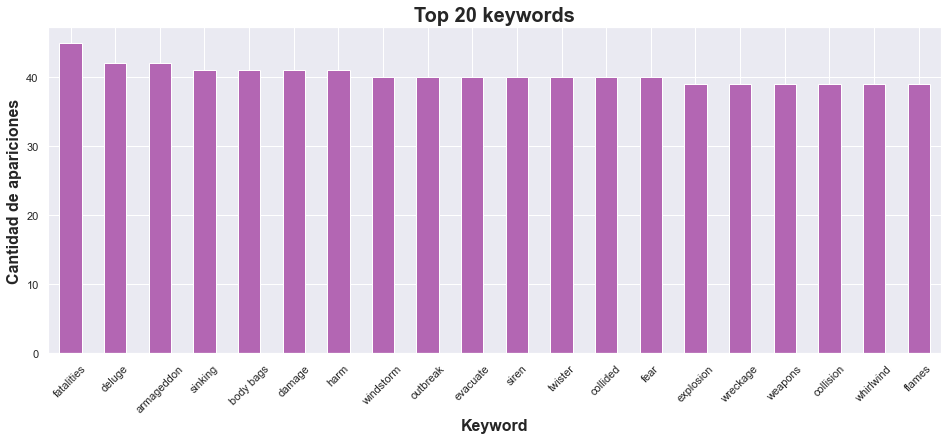

In [10]:
plot = train_df['keyword'].value_counts()[0:20].plot(kind='bar',figsize=(16,6), color=(0.7,0.4,0.7))

plot.set_title('Top 20 keywords', fontsize=20,weight='bold');
plot.set_xlabel('Keyword', fontsize=16,weight='bold')
plot.set_ylabel('Cantidad de apariciones', fontsize=16,weight='bold')

plt.xticks(rotation=45);

Vamos a analizar los keyword en función del target.

In [11]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

derailment     39
outbreak       39
wreckage       39
oil spill      37
typhoon        37
               ..
body bags       1
ruin            1
electrocute     1
body bag        1
epicentre       1
Name: keyword, Length: 220, dtype: int64

In [12]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
harm               37
armageddon         37
deluge             36
ruin               36
                   ..
oil spill           1
outbreak            1
suicide bombing     1
suicide bomber      1
typhoon             1
Name: keyword, Length: 218, dtype: int64

In [13]:
df1 = keywords_verdaderos.value_counts().to_frame().reset_index()
df1.columns = ['keyword','count']

df2 = keywords_falsos.value_counts().to_frame().reset_index()
df2.columns = ['keyword','count']

merge_keywords = pd.merge(df1,df2,how='outer',on='keyword')
merge_keywords.head()

,keyword,count_x,count_y
0,derailment,39.0,NaN
1,outbreak,39.0,1.0
2,wreckage,39.0,NaN
3,oil spill,37.0,1.0
4,typhoon,37.0,1.0


In [14]:
merge_keywords.fillna(value=0,inplace=True)

In [15]:
merge_keywords.rename(columns={'count_x':'cantidad_verdaderos','count_y':'cantidad_falsos'},inplace=True)

In [16]:
merge_keywords.head()

,keyword,cantidad_verdaderos,cantidad_falsos
0,derailment,39.0,0.0
1,outbreak,39.0,1.0
2,wreckage,39.0,0.0
3,oil spill,37.0,1.0
4,typhoon,37.0,1.0


In [17]:
merge_keywords['porcentaje_verdaderos'] = (merge_keywords['cantidad_verdaderos'] / (merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos'])) * 100

In [18]:
merge_keywords.set_index('keyword',inplace=True)

In [19]:
merge_keywords.head()

,cantidad_verdaderos,cantidad_falsos,porcentaje_verdaderos
keyword,,,
derailment,39.0,0.0,100.000000
outbreak,39.0,1.0,97.500000
wreckage,39.0,0.0,100.000000
oil spill,37.0,1.0,97.368421
typhoon,37.0,1.0,97.368421


Vamos a analizar los keyword en función del porcentaje de tweets verdaderos. Para ello, vamos a considerar como significativos los keywords que tengan por lo menos 30 tweets.

Veamos los 10 keyword con mayor porcentaje de tweets verdaderos.

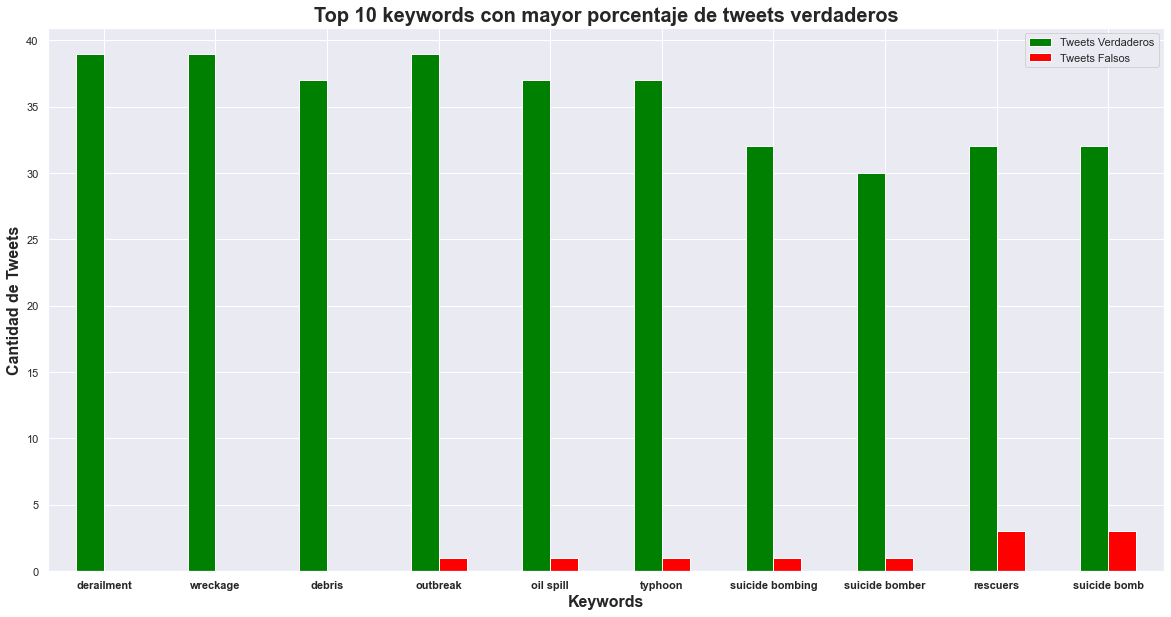

In [20]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Top 10 keywords con mayor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Ahora veamos los 10 keywords con el menor porcentaje de tweets verdaderos siguiendo el mismo criterio de antes.

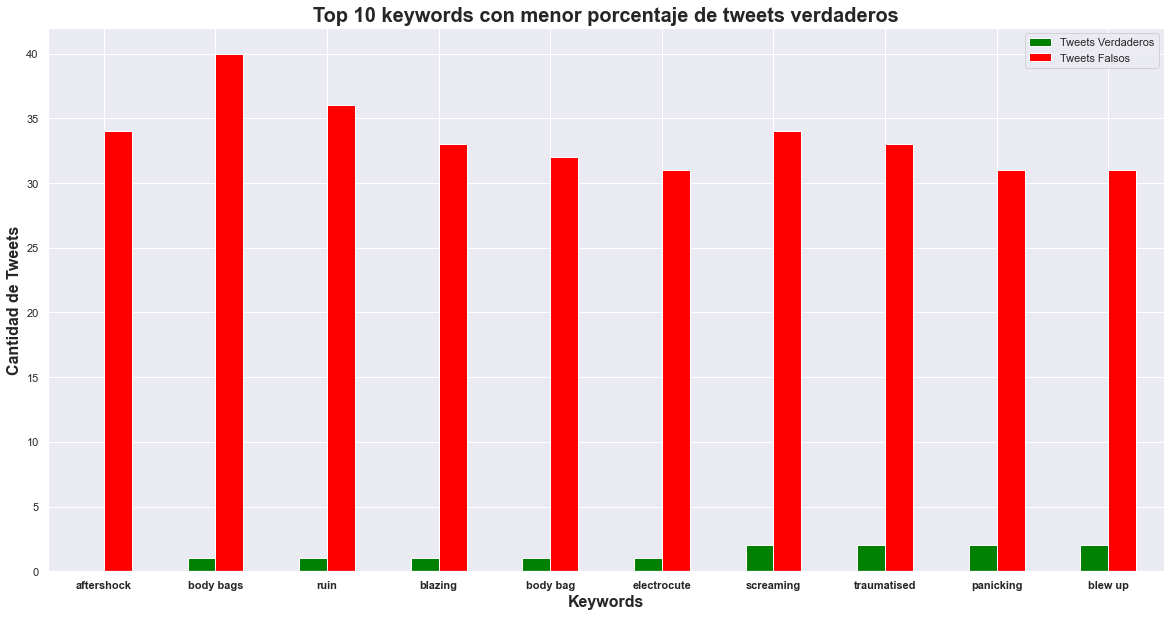

In [21]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nsmallest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Top 10 keywords con menor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Finalmente, vemos los keywords que tienen una cantidad similar de tweets verdaderos y falsos.

In [22]:
porcentajes_parecidos = (merge_keywords['porcentaje_verdaderos']>=48) & (merge_keywords['porcentaje_verdaderos']<=52)

merge_parecidos = merge_keywords[porcentajes_parecidos]
merge_parecidos

,cantidad_verdaderos,cantidad_falsos,porcentaje_verdaderos
keyword,,,
explosion,20.0,19.0,51.282051
bombed,19.0,19.0,50.000000
storm,18.0,17.0,51.428571
hail,18.0,17.0,51.428571
lightning,17.0,16.0,51.515152
derail,17.0,18.0,48.571429
rescued,17.0,18.0,48.571429
hijack,16.0,17.0,48.484848
hostage,15.0,16.0,48.387097


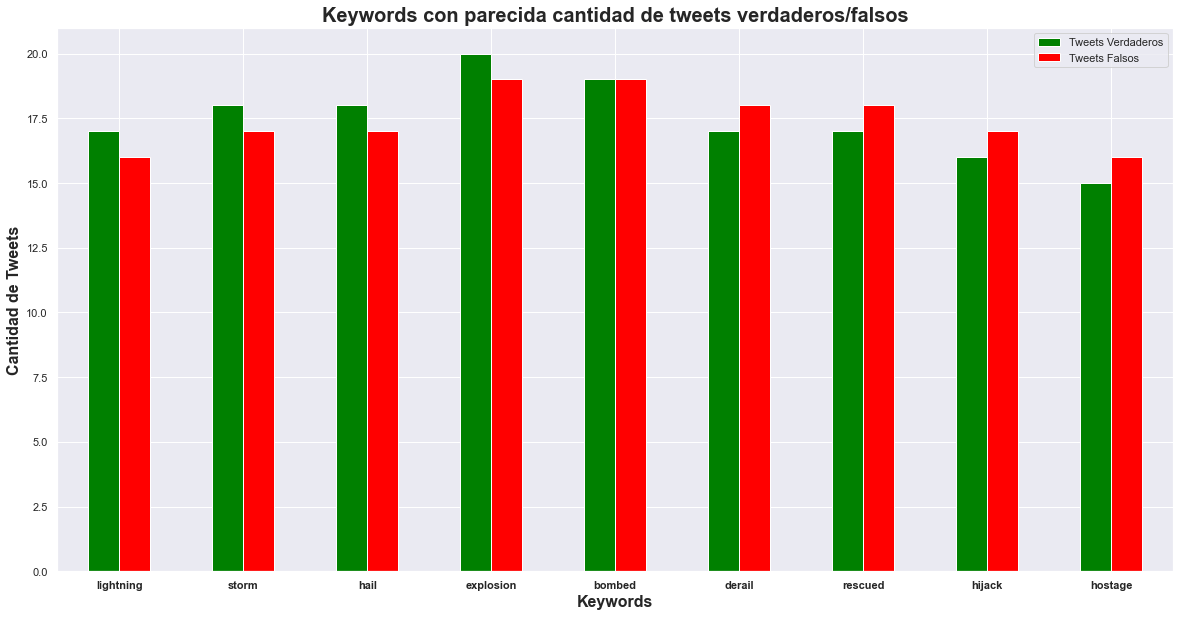

In [23]:
df_aux = merge_parecidos.loc[(porcentajes_parecidos)].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0,weight='bold')

plt.title('Keywords con parecida cantidad de tweets verdaderos/falsos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

## Análisis del campo location<a id='link_3'></a>

In [24]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [25]:
train_df['location'].sample(30)

167                  San Francisco, CA
6998                          Plano,TX
1933                               NaN
2192                         Tampa, FL
3118                             ?????
1133                               NaN
6040                   the azure cloud
7419                               NaN
7453                         Cape Town
2164                               NaN
1617             Sandton, South Africa
7460        ?Gangsta OC / MV RP; 18+.?
6560                       Puerto Rico
535                         Denver, CO
3662     playing soccer & eating pizza
2590                               USA
6815        LITTLETON, CO, USA, TERRAN
591                                NaN
3397              |IG: imaginedragoner
1940                        California
3679                             U.S.A
2513                               NBO
5058      Newcastle Upon Tyne, England
3166                               NaN
7442                             Earth
4920                  GLO

Se observa que la ubicacion ingresada no es siempre algo coherente. Veamos las ubicaciónes no nulas con mayor cantidad de tweets.

In [26]:
locations_count = train_df['location'].value_counts()
locations_count

USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
                                 ... 
Fort Valley,GA/Fayetteville,AR      1
death star                          1
Bushkill pa                         1
Paris, France                       1
Aro Diaspora                        1
Name: location, Length: 3341, dtype: int64

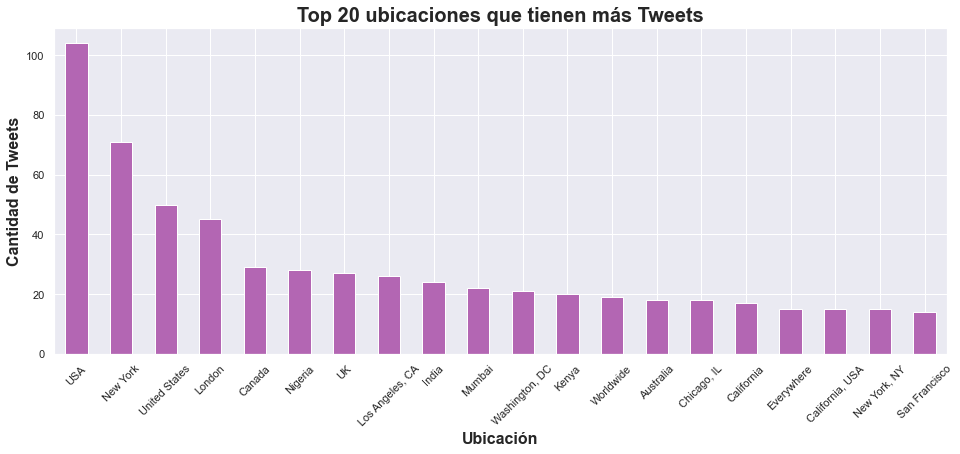

In [27]:
plot = train_df['location'].value_counts()[0:20].plot(kind='bar',figsize=(16,6), color=(0.7,0.4,0.7))

plot.set_title('Top 20 ubicaciones que tienen más Tweets', fontsize=20,weight='bold');
plot.set_xlabel('Ubicación', fontsize=16,weight='bold')
plot.set_ylabel('Cantidad de Tweets', fontsize=16,weight='bold')

plt.xticks(rotation=45);

Veamos las ubicaciones que tienen un único tweet.

In [28]:
location_with_one_tweet = locations_count[locations_count == 1]
location_with_one_tweet.sample(15)

seattle wa                      1
The Jewfnited State             1
Upper manhattan, New York       1
???? ???????                    1
Wyoming, MI (Grand Rapids)      1
Alberta, VA                     1
Beirut/Toronto                  1
Balikesir - Eskisehir           1
???????, ??'??????              1
Ã¥_Ã¥_Los Mina CityÂÃ£Â¢       1
Daddy Kink Central              1
Madisonville TN                 1
Newton Centre, Massachusetts    1
570 Vanderbilt; Brooklyn, NY    1
ÃÃT: 6.4682,3.18287           1
Name: location, dtype: int64

In [29]:
print("Ubicaciones con un único tweet:",location_with_one_tweet.count());
print("Ubicaciones diferentes:",len(train_df['location'].unique()))
print("Porcentaje de ubicaciones que solo aparecen 1 vez:",location_with_one_tweet.count()/len(train_df['location'].unique())*100)

Ubicaciones con un único tweet: 2818
Ubicaciones diferentes: 3342
Porcentaje de ubicaciones que solo aparecen 1 vez: 84.32076600837821


Aproximadamente el 84,3% de las ubicaciones tienen un sólo tweet. ¿Cuántas de esas corresponden a tweets falsos?

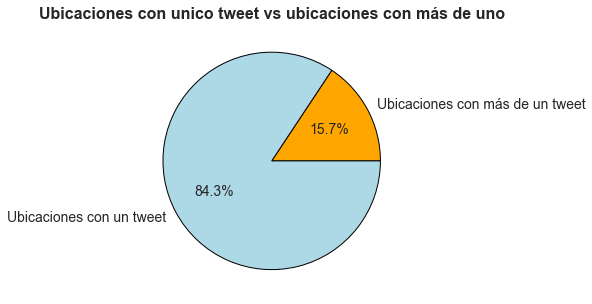

In [30]:
total = len(train_df['location'].unique())
unicos = location_with_one_tweet.count()

slices = [total-unicos,unicos]
m_labels = ['Ubicaciones con más de un tweet','Ubicaciones con un tweet']
m_colors = ['orange','lightblue']

plt.figure(figsize=(5,5))
plt.pie(slices,labels=m_labels,colors = m_colors,autopct ='%1.1f%%', wedgeprops={'edgecolor':'black'},textprops={'fontsize': 14})

plt.title("Ubicaciones con unico tweet vs ubicaciones con más de uno",fontsize=16,weight='bold')
plt.show()

In [31]:
tweets_one_location = train_df.groupby("location").filter(lambda x: len(x) == 1)
tweets_one_location.head()

,id,keyword,location,text,target
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,False
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,True
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,False
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,False


In [32]:
tweets_one_location['target'].value_counts()

False    1716
True     1102
Name: target, dtype: int64

Vemos que aproximadamente, de estos tweets, el 60,9% resultan ser falsos.

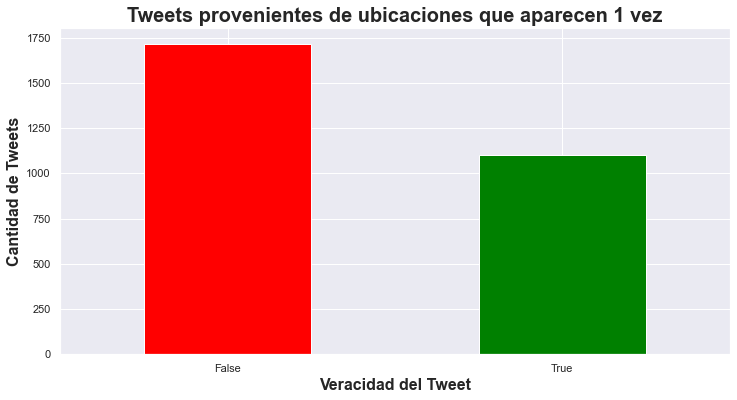

In [33]:
tweets_one_location['target'].value_counts().plot.bar(figsize=(12,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Tweets provenientes de ubicaciones que aparecen 1 vez', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Veracidad del Tweet', fontsize=16,weight='bold');

In [34]:
train_df['target'].value_counts()

False    4342
True     3271
Name: target, dtype: int64

En relacion a todos los registros, representa el 39,5% de los tweets falsos, y casi 33,7% de los verdaderos.

Veamos ahora considerando también los casos en donde la ubicación es desconocida.

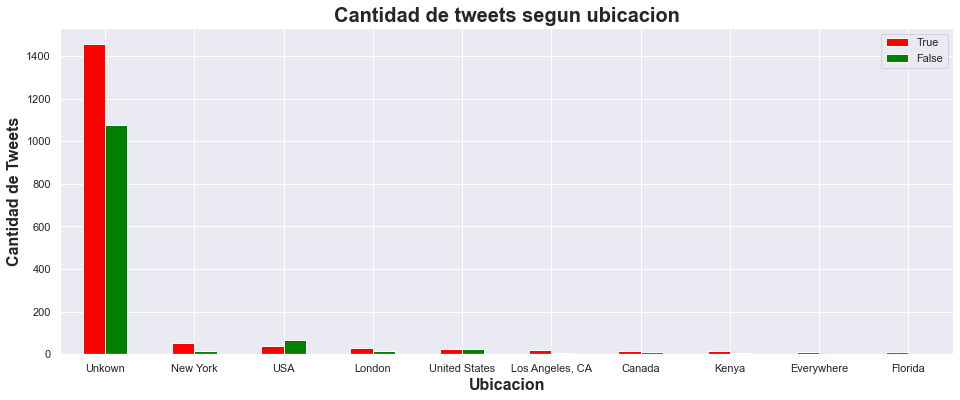

In [35]:
df = train_df
df['location'].fillna('Unkown',inplace=True)
df = df[['location','target','id']].groupby(['location','target']).count().unstack().fillna(0)
df.columns=['True','False']
df.sort_values(by='True',ascending=False,inplace=True)

df.head(10).plot.bar(figsize=(16,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Cantidad de tweets segun ubicacion', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Ubicacion', fontsize=16,weight='bold');

## Análisis de la cantidad de palabras de los tweets<a id='link_4'></a>

In [36]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

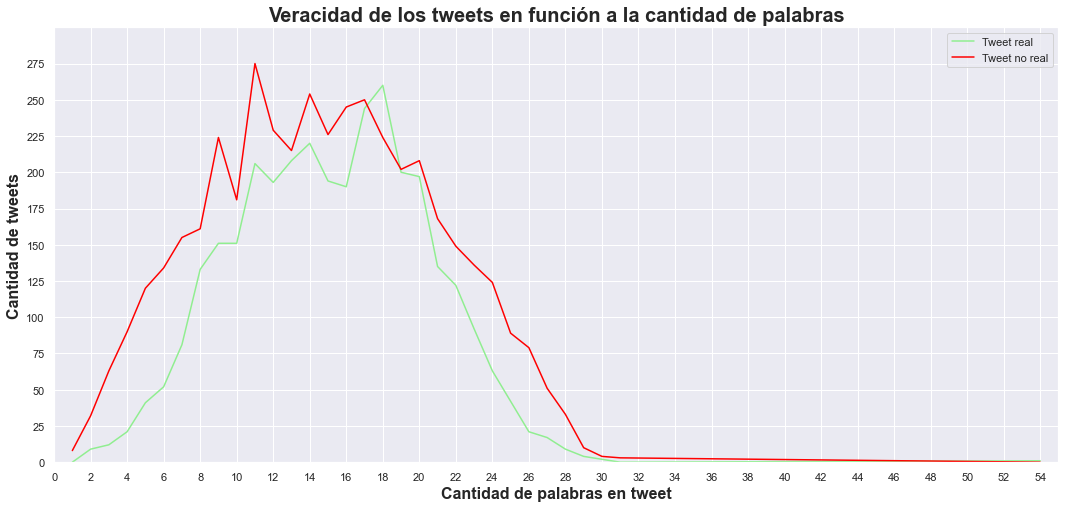

In [37]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="lightgreen", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')

ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Veracidad de los tweets en función a la cantidad de palabras', fontsize=20,weight='bold')
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16,weight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16,weight='bold');

## Análisis de la longitud de los tweets<a id='link_5'></a>

In [38]:
train_df['longitud_del_tweet'] = train_df['text'].str.len()

Analizamos las estadísticas de la longitud en los tweets verdaderos.

In [39]:
train_df[train_df['target']]['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,3271.0,108.444207,29.511567,14.0,88.0,115.0,136.0,161.0


Analizamos las estadísticas de la longitud en los tweets falsos.

In [40]:
train_df[~train_df['target']]['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,4342.0,95.981345,36.100118,7.0,68.0,101.0,130.0,163.0


In [41]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

Realizamos un gráfico para poder visualizar mejor las estadísticas de la longitud de los tweets según su target.

Text(0, 0.5, 'Longitud')

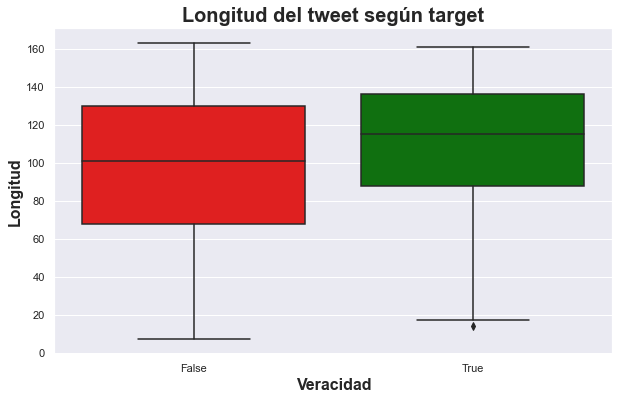

In [42]:
plt.figure(figsize=(10,6))

g = sns.boxplot(x="target",y="longitud_del_tweet", data=train_df,palette=['red','green'])

g.set_title("Longitud del tweet según target", fontsize=20, fontweight='bold')
g.set_xlabel("Veracidad", fontsize=16, fontweight='bold')
g.set_ylabel("Longitud",fontsize=16, fontweight='bold')

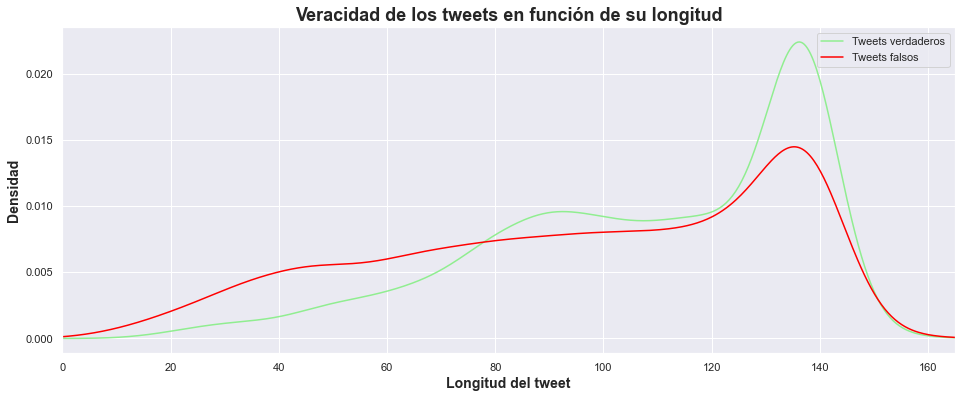

In [43]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=14, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=14, fontweight='bold')

ax.set_xlim(0, 165) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Covarianza y Correlación<a id='link_6'></a>

In [44]:
train_df['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,7613.0,101.336136,33.991338,7.0,78.0,107.0,134.0,163.0


Vamos a analizar más en detalle que va sucediendo a medida que la longitud crece; que sucede con el target, es "más real" o no el tweet?<br>
Creamos unas categorías segun lo visto anteriormente donde de todas las longitudes el 25% promedio esta en 78, el 50% en 107 y así... la idea de estas categorías es agrupar rangos entre 0 a 25 , 25 a 50 , 50 a 75 y 75 a 100 segun estas medidas obtenidas.

In [45]:
train_df.loc[train_df['longitud_del_tweet']<78.0,'Categ']="0 a 25"
train_df.loc[train_df['longitud_del_tweet']>=78.0,'Categ']="25 a 50"
train_df.loc[train_df['longitud_del_tweet']>=107.0,'Categ']= "50 a 75"
train_df.loc[train_df['longitud_del_tweet']>=134.0,'Categ']= "75 a 100"

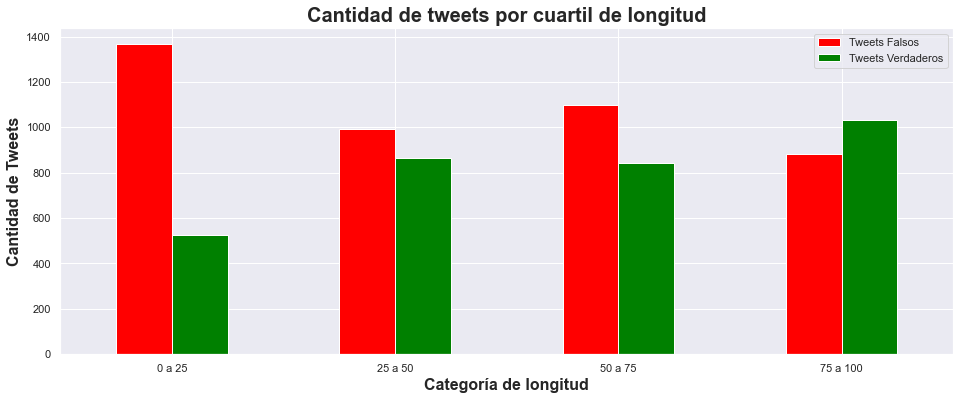

In [46]:
df_aux = train_df.groupby(['Categ','target'])['id'].count().unstack()
df_aux.columns = ['Tweets Falsos','Tweets Verdaderos']
df_aux.plot.bar(figsize=(16,6), color=('red','green'));
plt.xticks(rotation=0)

plt.title('Cantidad de tweets por cuartil de longitud', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Categoría de longitud', fontsize=16,weight='bold');

Podemos ver que a una longitud menor es más probable que sea un tweet falso y que cuanto más largo sea el tweet mayor su probabilidad de ser real.<br>
Ahora vamos a analizar cual es la covarianza y correlacion entre estas categorias creadas en base a su longitud (como largo de la cadena) vs target.

In [47]:
df_aux = train_df
df_aux['Categ_A'] = np.where(df_aux['Categ']=="0 a 25",1,0)
df_aux['Categ_B'] = np.where(df_aux['Categ']=="25 a 50",1,0)
df_aux['Categ_C'] = np.where(df_aux['Categ']=="50 a 75",1,0)
df_aux['Categ_D'] = np.where(df_aux['Categ']=="75 a 100",1,0)

In [48]:
df_aux[['Categ_A','Categ_B','Categ_C','Categ_D','longitud_del_tweet','target']].corr()

,Categ_A,Categ_B,Categ_C,Categ_D,longitud_del_tweet,target
Categ_A,1.000000,-0.327100,-0.337233,-0.333972,-0.820184,-0.176486
Categ_B,-0.327100,1.000000,-0.332614,-0.329397,-0.154991,0.042091
Categ_C,-0.337233,-0.332614,1.000000,-0.339601,0.337340,0.005319
Categ_D,-0.333972,-0.329397,-0.339601,1.000000,0.631737,0.128873
longitud_del_tweet,-0.820184,-0.154991,0.337340,0.631737,1.000000,0.181513
target,-0.176486,0.042091,0.005319,0.128873,0.181513,1.000000


Podemos ver como aumenta la correlacion un poco a medida que la logitud aumenta, pero esto no nos indica si aumenta según si es o no real.

## Análisis de menciones<a id='link_7'></a>

Vamos a analizar la naturaleza de los tweets en base a si se realiza alguna mención en el mismo o no.

In [49]:
train_df['tiene_menciones'] = train_df['text'].str.contains('@')
train_df['tiene_menciones'].value_counts()

False    5574
True     2039
Name: tiene_menciones, dtype: int64

Podemos ver que aproximadamente en el 26.7% de los tweets se realizan menciones a otro usuario.

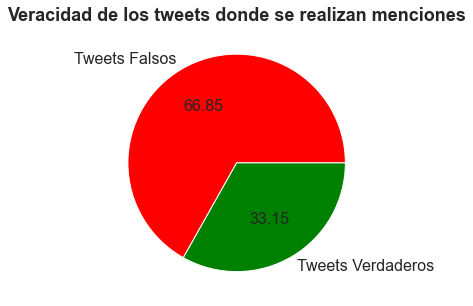

In [50]:
train_df.loc[train_df['tiene_menciones']]['target'].value_counts().plot.pie(labels=['Tweets Falsos','Tweets Verdaderos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets donde se realizan menciones',fontsize=18,weight='bold');

Podemos ver que en 2/3 de los tweets en donde se realiza alguna mención, el tweet resulta ser falso.

## Análisis de "tweets expresivos"<a id='link_8'></a>

Consideramos como "tweet expresivo" a los tweets en donde se utiliza múltiples signos de exclamación o interrogación consecutivos.

In [51]:
train_df['es_expresivo'] = (train_df['text'].str.contains('\!\!') | train_df['text'].str.contains('\?\?'))
train_df['es_expresivo'].value_counts()

False    6972
True      641
Name: es_expresivo, dtype: int64

Vemos que solo en **641** registros se usan signos de exclamación o interrogación consecutivos, menos del 10% del set de datos.

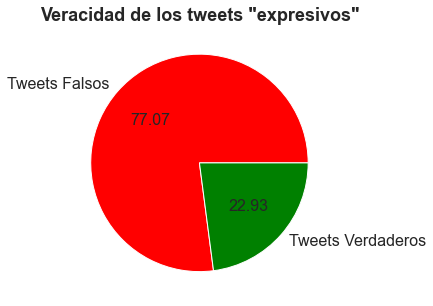

In [52]:
train_df.loc[train_df['es_expresivo']]['target'].value_counts().plot.pie(labels=['Tweets Falsos','Tweets Verdaderos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets "expresivos"',fontsize=18,weight='bold');

Como podría esperarse, los tweets en donde se utilizan signos de puntuación de manera exagerada, en general para resaltar una emoción del usuario, no suelen ser sobre noticias reales.

### Hay algún registro que el <i><b>text</b></i> NO contenga la <i><b>keyword</b></i>?<a id='link_9'></a>

In [53]:
def f_aux(row):
  if str(row['keyword']).lower() in str(row['text']).lower():
    return True
  return False

train_df['contiene_key'] = train_df.loc[~train_df['keyword'].isnull()].apply(f_aux,axis=1)

In [54]:
train_df['contiene_key'].value_counts()

True     6700
False     852
Name: contiene_key, dtype: int64

In [55]:
train_df.loc[train_df['contiene_key']==False].head(10)[['keyword','text']]

,keyword,text
32,ablaze,We always try to bring the heavy. #metal #RT h...
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
45,ablaze,I gained 3 followers in the last week. You? Kn...
48,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
49,ablaze,First night with retainers in. It's quite weir...
52,ablaze,SANTA CRUZ ÂÃÃ Head of the St Elizabeth Pol...
54,ablaze,Noches El-Bestia '@Alexis_Sanchez: happy to se...
83,accident,#TruckCrash Overturns On #FortWorth Interstate...
103,aftershock,'The man who can drive himself further once th...
105,aftershock,'There is no victory at bargain basement price...


In [56]:
train_df.loc[train_df['contiene_key']==False]['target'].value_counts()

False    500
True     352
Name: target, dtype: int64

Podemos observar que de todos los datos que tienen keyword válido, <b>6700</b> 
son los que contienen exactamente la palabra. Los otros <b>852</b> son interpretaciones del tweet o ruido. No se considera que vale la pena quitar 852 registros por la posibilidad de que la mayoria sean o no ruido.

## Análisis de hashtags<a id='link_10'></a>

Armamos una lista con los hashtag que contiene el tweet.

In [57]:
train_df['cantidad_de_hashtags'] = train_df['text'].str.count('#')

In [58]:
import re
def split_hashtag(hashtag):
    return re.findall(r"#(\w+)",hashtag)

train_df['hashtags'] = train_df['text'].apply(split_hashtag)

In [59]:
train_df['cantidad_de_hashtags'].value_counts()

0     5852
1      964
2      405
3      208
4       83
5       41
6       26
10      10
7        8
8        8
13       4
11       2
9        2
Name: cantidad_de_hashtags, dtype: int64

In [60]:
df = train_df[['hashtags']].explode('hashtags').dropna()
top20_hashtags = df['hashtags'].value_counts().head(40).to_list()

top20_hashtags = [str(hashtag).lower() for hashtag in top20_hashtags]

Vamos a ver los hashtags que más aparecen en los tweets.<br>
Para esto, vamos a hacer uso de lo que sería una normalizacion de palabras para poder "agrupar" de mejor forma, por ejemplo:
* rocks : rock
* corpora : corpus
* better : good

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FF633NG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


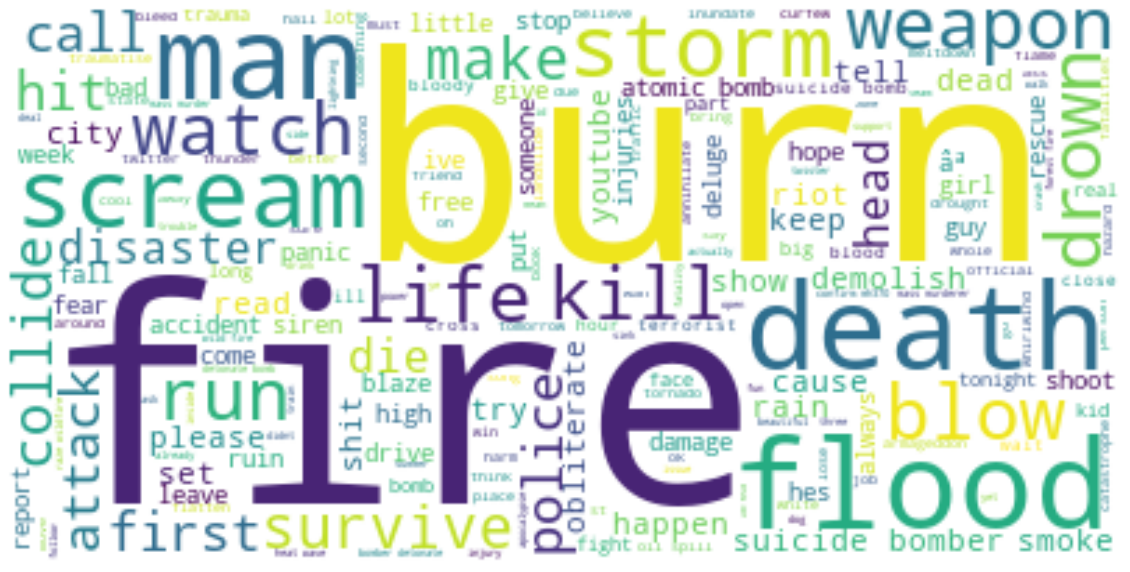

In [61]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

df=train_df.copy()

#vamos a limpiar un poco el tweet
pattern_exclude = '(one|dont|cant|would|im|people|go|make|time|love|amp|get|house|update|talk'+\
                  '|want|today|know|say|us|day|crush|see|back|think|look|rigth|remember|car'+\
                  '|thing|let|still|lol|much|thank|take|way|youre|road|another|really|save'+\
                  '|play|even|theres|everyone|feel|year|work|check|two|great|ing|like|sink'+\
                  '|every|build|youtuve|video|n|home|body|bag|photo|stay|game|start|gt|fuck|help'+\
                  '|best|well|california|end|live|e|rt|wreck|plan|full|may|ies|u|could|many|last'+\
                  '|find|service|leave|collapse|world|war|destroy|wound|break|right|hear|school)+'

def filter_words(tweet):
    tweet = re.sub(r'(\b[\w]+:\/\/[\w -\?&;#~=\.\/@]+[\w\/])', ' ', tweet)
    tweet = re.sub(r'\'', '', tweet)
    return re.sub(r'[www.]*[A-z]+.(com|gov|edu|net|mil|org|io|int)+', ' ', tweet)

def text_to_blob(tweet):
    tweet_blob = TextBlob(str(tweet))
    return ' '.join(tweet_blob.words)


def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            word_aux = word.lower().strip()
            if re.match(pattern_exclude,
                        word_aux):
                continue
            normalized_text = lem.lemmatize(word_aux,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet

def clean(tweet):
    tweet_list = [word for word in (text_to_blob(filter_words(tweet))).split()]
    clean_tokens = [tkn for tkn in tweet_list if re.match(r'[A-z]+', tkn)]
    clean_s = ' '.join(clean_tokens)
    l_aux = normalization(clean_s.split())
    return ' '.join([word for word in l_aux if word not in stopwords.words('english')])

df['clean_text'] = df['text'].apply(clean)

text = df['clean_text'].str.split(' ').to_frame().explode('clean_text')['clean_text'].str.cat(sep=' ').lower()

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos ver algunas palabras que podrian resultar impotantes como:
* FIRE
* POLICE
* WEAPON
* EMERGENCY
* HELP
* DEAD
* DAMAGE
* SMOKE
* SUICIDE
* BOMBER
* ATTACK
* FEAR
* CAUSE
* MILITARY

In [62]:
def f_aux(hashtags):
    for hashtag in hashtags:
        if str(hashtag).lower() in ['fire','police','weapon','emergency','help','dead','damage','smoke',
              'suicide','bomber','military','attack','blood','accident','fear','cause']:
            return True
    return False
train_df['hashtag_importante'] = train_df['hashtags'].apply(f_aux)

In [63]:
train_df.loc[train_df['hashtag_importante']==True]['target'].value_counts()

False    11
True     10
Name: target, dtype: int64

No encontramos nada con hashtags y estas palabras, pero veamos los textos que contengan estas que sucede.

In [64]:
def f_aux(texto):
    for w in ['fire','police','weapon','emergency','help','dead','damage','smoke',
              'suicide','bomber','military','attack','blood','accident','fear','cause']:
        if w in str(texto).lower():
            return True
    return False

train_df['texto_importante'] = train_df['text'].apply(f_aux)

In [65]:
train_df.loc[train_df['texto_importante']==True]['target'].value_counts()

True     1006
False     718
Name: target, dtype: int64

In [66]:
train_df.shape

(7613, 20)

Igualmente como vimos al inicio, **5852** de los tweets no tienen hashtag, lo que nos deja el set bastante reducido de **1761** registros.

Veamos puntualmente estas palabras que se remarcan en el gráfico que sucede.

In [67]:
df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False).head(15)

fire        354
bomb        228
burn        180
kill        168
flood       164
disaster    152
crash       150
attack      149
police      137
train       127
storm       125
watch       118
suicide     114
scream      112
man         110
Name: clean_text, dtype: int64

Cuántas de estas son keyword ? Qué sucede con estas palabras y el target?

Text(0, 0.5, 'Cantidad de tweets')

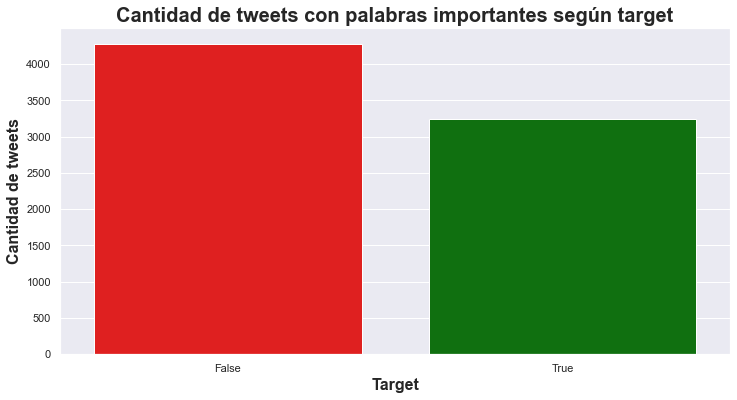

In [68]:
important_words = df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False)
important_words = important_words.reset_index()['index'].to_list()

def f_aux(tweet):
    for word in important_words:
        if word in tweet:
            return True
    return False

df['important_word_match_text'] = df['clean_text'].apply(f_aux)
df_aux = df.loc[df['important_word_match_text']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Cantidad de tweets con palabras importantes según target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

Esto con todas las palabras filtradas no nos sirve de mucho, veamos con el top15 que sucede.

Text(0, 0.5, 'Cantidad de tweets')

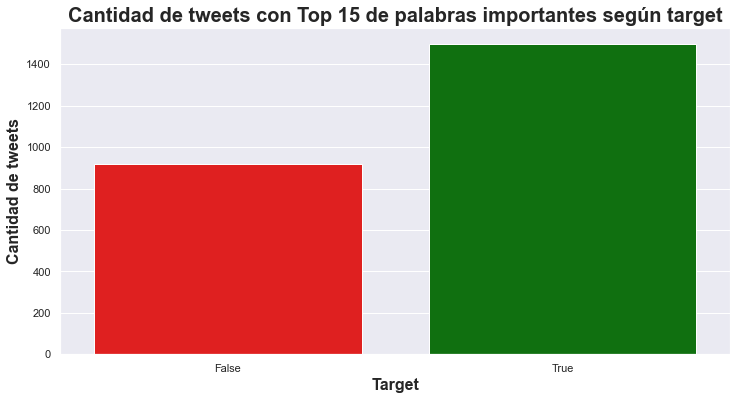

In [69]:
important_words = df['clean_text'].str.split().to_frame().explode('clean_text')['clean_text'].value_counts(ascending=False).head(15)
important_words = important_words.reset_index()['index'].to_list()

def f_aux(tweet):
    for word in important_words:
        if word in tweet:
            return True
    return False

df['important_word_match_text'] = df['clean_text'].apply(f_aux)
df_aux = df.loc[df['important_word_match_text']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Cantidad de tweets con Top 15 de palabras importantes según target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

Podemos observar que con el top 15 de palabras importantes vemos mayor tendencia a que sea un tweet veraz!

Ahora, de estos registros con match de palabras importantes hay alguna coincidencia con el keyword? Si está vacío se lo podría completar?

Text(0, 0.5, 'Cantidad de tweets')

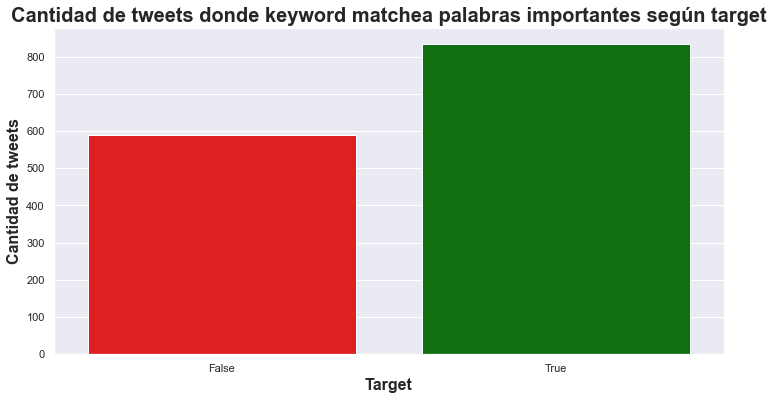

In [70]:
def f_aux(keyword):
    for word in important_words:
        if word in str(keyword):
            return True
    return False

df['important_word_match_keyword'] = df['keyword'].apply(f_aux)
df_aux = df.loc[df['important_word_match_keyword']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Cantidad de tweets donde keyword matchea palabras importantes según target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

Text(0, 0.5, 'Cantidad de tweets')

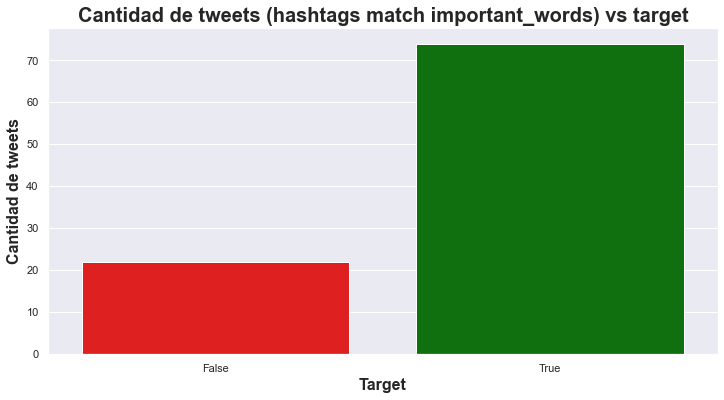

In [71]:
def f_aux(hashtags):
    for word in important_words:
        if any(word in ele for ele in hashtags):
            return True
    return False

df['important_word_match_hashtag'] = df['hashtags'].apply(f_aux)
df_aux = df.loc[df['important_word_match_hashtag']==True]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Cantidad de tweets (hashtags match important_words) vs target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

Text(0, 0.5, 'Cantidad de tweets')

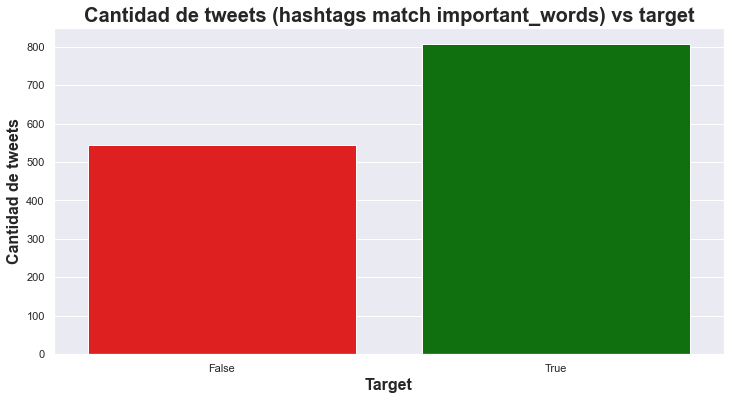

In [72]:
df_aux = df.loc[(df['important_word_match_text']==True)&(df['important_word_match_keyword']==True)]

plt.figure(figsize=(12,6))

ax = sns.countplot(x= 'target',data = df_aux,palette=['red','green']);

plt.title('Cantidad de tweets (hashtags match important_words) vs target', fontsize=20,weight='bold')
ax.set_xlabel('Target', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de tweets', fontsize=16, fontweight='bold')

No son demasiados los registros que se esan analizando, son 1400 aproximadamente, pero nos da un indicio que con estas palabras hay mayor tendencia a que el tweet sea real.

## Categorización tweet si es terrorista<a id='link_11'></a>

In [73]:
def split_hashtag(word):
    return (len(re.findall(r"(?:bomb|attack|emergency|terrorism|blood|violent|crime|hurt|kill)",word))!=0)

train_df['categ_emergencia'] = train_df['text'].apply(split_hashtag)

In [74]:
df = train_df.loc[train_df['categ_emergencia']==True]

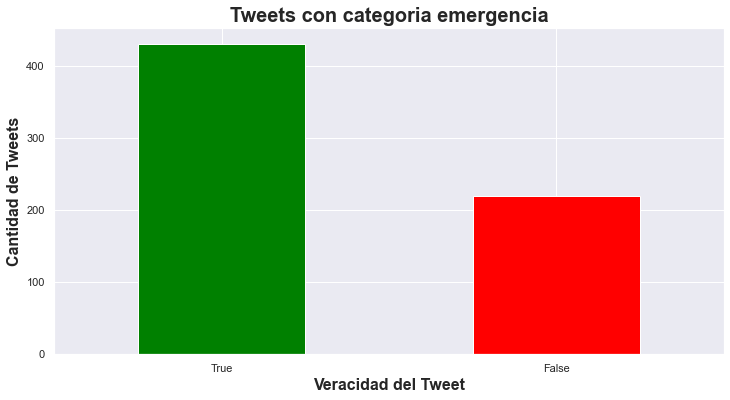

In [75]:
df['target'].value_counts().plot.bar(figsize=(12,6), color=('green','red'));
plt.xticks(rotation=0)
plt.title('Tweets con categoria emergencia', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');
plt.xlabel('Veracidad del Tweet', fontsize=16,weight='bold');

## Análisis de links<a id='link_12'></a>

Veamos si hay alguna relación entre los tweets que tienen links y su veracidad.

In [76]:
train_df['text'].str.contains('http').value_counts()

True     3971
False    3642
Name: text, dtype: int64

Podemos ver que un poco más de la mitad (aproximadamente el **52,2%**) de los tweets tienen links en el texto.

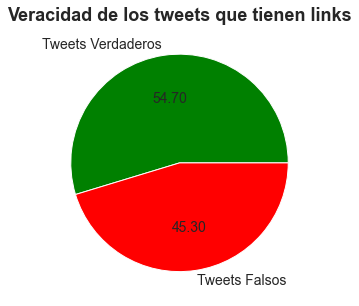

In [77]:
train_df.loc[train_df['text'].str.contains('http')]['target'].value_counts().plot.pie(labels=['Tweets Verdaderos','Tweets Falsos'],\
                                                figsize=(5,5),autopct='%.2f', fontsize=14,colors=('green','red'))

plt.ylabel('');
plt.title('Veracidad de los tweets que tienen links',fontsize=18,weight='bold');

No parece que el hecho de que un tweet tenga un link o no sea determinante para la veracidad del mismo. Vamos a analizar más profundamente los links que aparecen en los tweets para poder determinar si hay links que se repitan en muchos casos.

In [78]:
import re
def split_links(text):
    return re.findall(r"(http[^ ]+)",text)

train_df['links'] = train_df['text'].apply(split_links)

In [79]:
links_df = train_df[['links','text','target']].explode('links').dropna()
links_df.head()

,links,text,target
31,http://t.co/lHYXEOHY6C,@bbcmtd Wholesale Markets ablaze http://t.co/l...,True
32,http://t.co/YAo1e0xngw,We always try to bring the heavy. #metal #RT h...,False
33,http://t.co/2nndBGwyEi,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
35,http://t.co/qqsmshaJ3N,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,False
37,http://t.co/3ImaomknnA,INEC Office in Abia Set Ablaze - http://t.co/3...,True


In [80]:
links_df['links'].value_counts()[links_df['links'].value_counts() > 1]

http://t.co/qew4c5M1xd    9
http://t.co/eNCmhz6y34    6
http://t.co/KSAwlYuX02    6
http://t.co/q2eBlOKeVE    6
http://t.co/vVPLFQv58P    5
                         ..
http://t.co/JlzK2HdeTG    2
http://t.co/LwwoJXtTIV    2
http://t.co/cT9ejXoLpu    2
http://t.co/vxVfAEEY0q    2
http://t.co/rOI2NSmEJJ    2
Name: links, Length: 72, dtype: int64

Podemos ver que hay 72 links que aparecen en más de un tweet, el más recurrente con 9 tweets; por lo que tampoco parece que haya algún caso de un "link que se repita en gran cantidad de tweets falsos o verdaderos" que nos sirva como indicador.

In [81]:
links_grouped = links_df.groupby(['links','target']).agg({'target':'count'}).rename(columns={'target':'cantidad_tweets'}).reset_index()
links_grouped.head()

,links,target,cantidad_tweets
0,http://t.co/007Npen6LG,True,1
1,http://t.co/00cY9vXEFF,False,1
2,http://t.co/02ELqLOpFk,True,1
3,http://t.co/03L7NwQDje,False,1
4,http://t.co/073izwX0lB,False,1


In [82]:
links_multitarget = links_grouped['links'].value_counts()[links_grouped['links'].value_counts() > 1].to_frame().index.to_list()
links_multitarget

['https://t.co/rqWuoy1fm4',
 'http://t.co/YdEtWgRibk',
 'http://t.co/0wrATkA2jL',
 'http://t.co/zujwUiomb3',
 'http://t.co/pyehwodWun',
 'http://t.co/cybKsXHF7d',
 'https://t.co/moLL5vd8yD',
 'http://t.co/aFMKcFn1TL',
 'https://t.co/e8dl1lNCVu',
 'http://t.co/q2eBlOKeVE',
 'http://t.co/vz1irH0Nmm',
 'http://t.co/JlzK2HdeTG',
 'http://t.co/eNCmhz6y34',
 'http://t.co/xpFmR368uF',
 'http://t.co/9NwAJLi9cr',
 'http://t.co/BbDpnj8XSx',
 'http://t.co/XsSgEdSbH4']

Vemos que hay links que aparecen tanto en tweets verdaderos como falsos. Vamos a analizar más en profundidad dichos links.

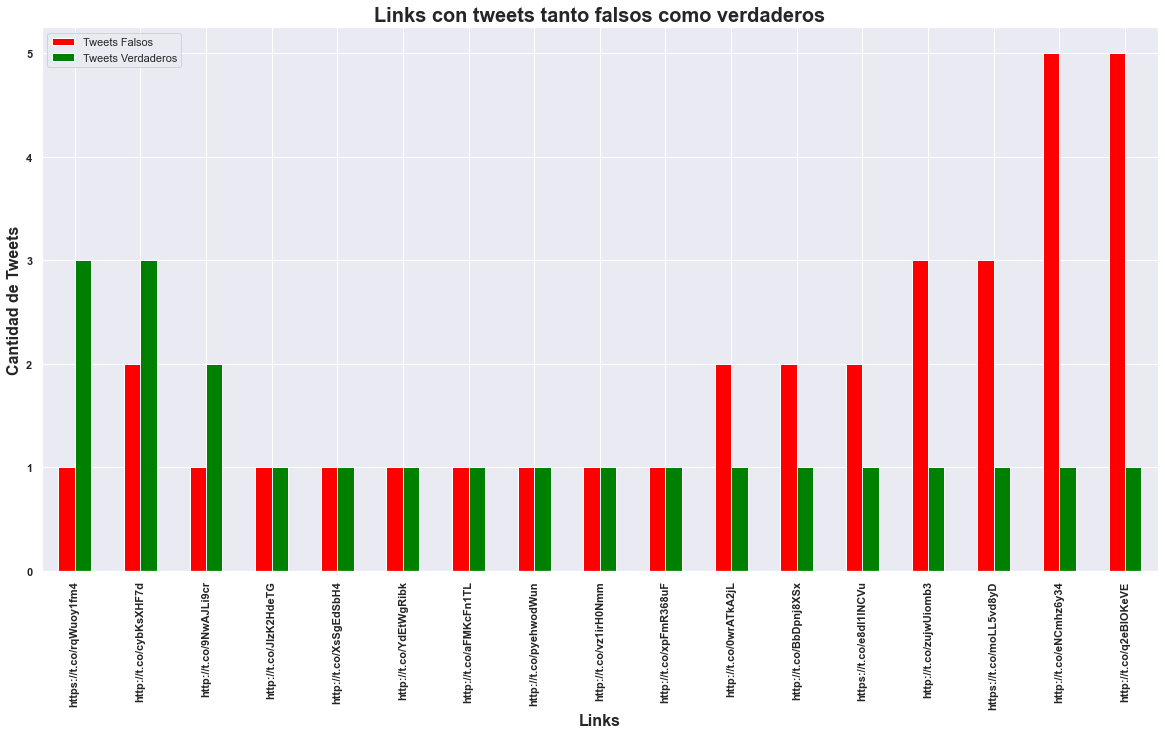

In [83]:
df_aux = links_df[links_df['links'].isin(links_multitarget)].groupby(['links','target'])['target'].count().unstack()

df_aux.columns = ['Tweets Falsos','Tweets Verdaderos']

df_aux.sort_values(['Tweets Verdaderos','Tweets Falsos'],ascending=[False,True]).plot.bar(figsize=(20,10),color=('red','green'));

plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Links con tweets tanto falsos como verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Links', fontsize=16,weight='bold')
plt.xticks(weight='bold')

plt.show()

In [84]:
links_df.loc[links_df['links'].isin(links_multitarget)].sort_values(['links','target'])[['text','target']]

,text,target
4149,@dinallyhot Love what you picked! We're playin...,False
4168,@5hvzlaRadio Love what you picked! We're playi...,False
4143,@leedsrouge Love what you picked! We're playin...,True
3012,The answer my friend is yelling in the wind-my...,False
2997,When the answer my friend isn't blowing in the...,True
3021,Wall of noise is one thing - but a wall of dus...,True
5072,This is the natural and unavoidable consequenc...,False
5078,This is the natural and unavoidable consequenc...,False
5066,This is the natural and unavoidable consequenc...,True
4379,RT NotExplained: The only known image of infam...,False


Vemos que en la mayoría de los casos el tweet es casi idéntico más allá de que cambie el target. Por lo tanto, suponemos que el target de estos registros en donde varía la veracidad puede deberse a un error a la hora de clasificar estos tweets.

## Análisis de "keyword" y "location" (para revisar y acomodar)

In [85]:
train_true_df = train_df.loc[train_df['target']==True]
train_false_df = train_df.loc[train_df['target']==False]

### keyword

Veamos algunas características de los datos de keyword en "train" y como se comportan en la apertura true/false.

In [86]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [87]:
train_true_df['keyword'].describe()

count           3229
unique           220
top       derailment
freq              39
Name: keyword, dtype: object

In [88]:
train_false_df['keyword'].describe()

count          4323
unique          218
top       body bags
freq             40
Name: keyword, dtype: object

Observamos que la mayoría aparecen en ambos, solo 4 valores aparecen en uno y no en el otro. Así como también observamos que la frecuencia es similar.

Ahora vamos a armar dos series para cruzar los datos de ambos df y comparar sus repeticiones.

In [89]:
keyword_true = train_true_df ['keyword'].value_counts().to_frame()
keyword_true.columns=['#keyword_true']
keyword_true

,#keyword_true
derailment,39
outbreak,39
wreckage,39
oil spill,37
typhoon,37
...,...
body bags,1
ruin,1
electrocute,1
body bag,1


In [90]:
keyword_false = train_false_df ['keyword'].value_counts().to_frame()
keyword_false.columns=['#keyword_false']
keyword_false

,#keyword_false
body bags,40
harm,37
armageddon,37
deluge,36
ruin,36
...,...
oil spill,1
outbreak,1
suicide bombing,1
suicide bomber,1


In [91]:
keyword_merge= keyword_true.merge (keyword_false,how='outer',left_index=True,right_index=True)
keyword_merge

,#keyword_true,#keyword_false
ablaze,13.0,23.0
accident,24.0,11.0
aftershock,NaN,34.0
airplane accident,30.0,5.0
ambulance,20.0,18.0
...,...,...
wounded,26.0,11.0
wounds,10.0,23.0
wreck,7.0,30.0
wreckage,39.0,NaN


In [92]:
keyword_merge.describe()

,#keyword_true,#keyword_false
count,220.000000,218.000000
mean,14.677273,19.830275
std,9.668498,9.487494
min,1.000000,1.000000
25%,6.000000,12.000000
50%,13.000000,20.000000
75%,22.250000,28.000000
max,39.000000,40.000000


Observamos que la cantidad de valores y el rango son similares, mientras que la concentración de repeticiones entre el 25% y el 75% es menor en keywords true.

Veamos los valores que no están en la intersección, es decir que solo aparecen en true o en false.

In [93]:
keyword_solo_true = keyword_merge [keyword_merge['#keyword_false'].isnull()]
keyword_solo_true

,#keyword_true,#keyword_false
debris,37.0,NaN
derailment,39.0,NaN
wreckage,39.0,NaN


In [94]:
keyword_solo_false = keyword_merge [keyword_merge['#keyword_true'].isnull()]
keyword_solo_false

,#keyword_true,#keyword_false
aftershock,NaN,34.0


Vemos que estás cuatro keywords son importantes para definir veracidad, ya que tienen una gran cantidad de repetiiones y están en un solo conjunto (true o false)

Ahora veamos que ocurre con las keywords que aparecen en la intersección, es decir que aparecen en true y en false, y la relación de repeticiones en cada conjunto.

In [95]:
keyword_merge_mixtos= keyword_true.merge (keyword_false,how='inner',left_index=True,right_index=True)
keyword_merge_mixtos

,#keyword_true,#keyword_false
outbreak,39,1
oil spill,37,1
typhoon,37,1
evacuated,32,4
rescuers,32,3
...,...,...
body bags,1,40
ruin,1,36
electrocute,1,31
body bag,1,32


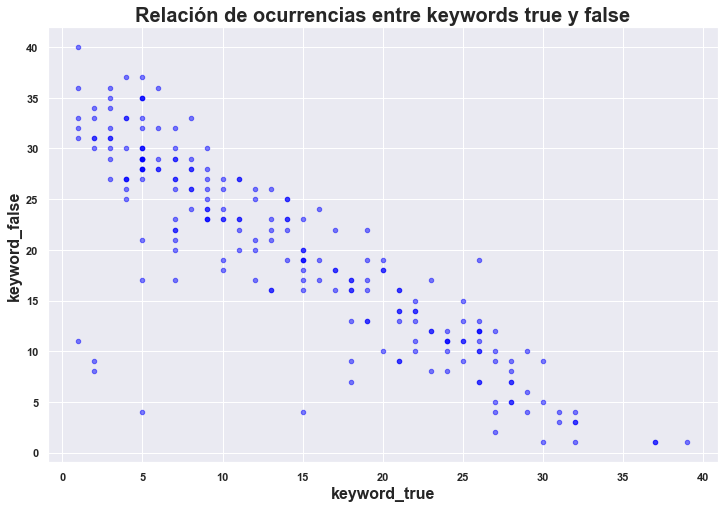

In [96]:
keyword_merge_mixtos.plot.scatter('#keyword_true','#keyword_false',c='Blue',title='Relación de ocurrencias entre keywords true y false',alpha=0.5,figsize=(12,8))
ax=plt.gca()
plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Relación de ocurrencias entre keywords true y false', fontsize=20,weight='bold')
plt.ylabel('keyword_false', fontsize=16,weight='bold')
plt.xlabel('keyword_true', fontsize=16,weight='bold');

Se observa que hay muchas keywords que tiene valores de repetición invertido entre el conjunto de true y false, es decir que hay keywords con alta ocurrencia en falsos y baja en true, y viceversa. De este modo podemos identificar grupos de preferencia false, otro true, y otro de similar ocurrencia. Podemos definir una relación entre ambos para cada keyword y darle un peso determinado para ayudar a ponderar el nuevo tweet.

### location

Veamos algunas caracteristicas de los datos de location en "train" y como se comportan en la apertura true/false.

In [97]:
train_df['location'].describe()

count       7613
unique      3342
top       Unkown
freq        2533
Name: location, dtype: object

In [98]:
train_true_df['location'].describe()

count       3271
unique      1514
top       Unkown
freq        1075
Name: location, dtype: object

In [99]:
train_false_df['location'].describe()

count       4342
unique      2143
top       Unkown
freq        1458
Name: location, dtype: object

In [100]:
(1513+2142)-3341

314

In [101]:
(314/3341)*100

9.398383717449866

Observamos que en su mayoria las location en true y en false son diferentes. Menos del 10% (314 valores) de location aparecen en ambos casos. El resto, teniendo en cuenta su repetición, puede ayudar a ponderar un nuevo tweet.

Ahora veamos las repeticiones de cada location para cruzar los datos de ambos df y compararlos.

In [102]:
location_true = train_true_df ['location'].value_counts().to_frame()
location_true.columns=['#location_true']
location_true

,#location_true
Unkown,1075
USA,67
United States,27
Nigeria,22
India,20
...,...
livin in a plastic world,1
lugo,1
"Lehigh Valley, PA",1
"Camberwell, Melbourne",1


In [103]:
location_false = train_false_df ['location'].value_counts().to_frame()
location_false.columns=['#location_false']
location_false

,#location_false
Unkown,1458
New York,55
USA,37
London,29
United States,23
...,...
Your screen,1
"Lancashire, United Kingdom",1
Forging my Story,1
NBO,1


In [104]:
location_merge= location_true.merge (location_false,how='outer',left_index=True,right_index=True)
location_merge

,#location_true,#location_false
,1.0,NaN
Glasgow,NaN,1.0
"Melbourne, Australia",NaN,1.0
News,1.0,NaN
Ã¥_,NaN,1.0
...,...,...
Ã¥_: ?? ÃÃ ? : ?,NaN,1.0
Ã¥_Ã¥_Los Mina CityÂÃ£Â¢,NaN,1.0
Ã¥Â¡Ã¥Â¡Midwest ÂÃÂ¢ÂÃÂ¢,NaN,1.0
Ã¥Ã(?ÂÃÂ¢`?ÂÃÂ¢Ã¥Â«)??,NaN,1.0


In [105]:
location_merge.describe()

,#location_true,#location_false
count,1514.000000,2143.000000
mean,2.160502,2.026132
std,27.691054,31.526481
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1075.000000,1458.000000


Podemos observar que en su gran mayoría las locations aparecen solo una vez, tanto en en false como en true.

Ahora veamos que ocurre en cada conjunto: solo en true, solo en false y en la intersección.

In [106]:
location_solo_true = location_merge [location_merge['#location_false'].isnull()]

In [107]:
location_solo_true ['#location_true'].value_counts()

1.0    1102
2.0      74
3.0      12
4.0      11
Name: #location_true, dtype: int64

Se observa que la cantidad de repeticiones de location se concentran en 1, y a su vez tampoco existen locations con muchas repeticiones (máx=4). Esto no nos ayuda mucho porque aunque son valores que solo aparecen en true, no suman mucho peso por la baja cantidad de repeticiones. 

In [108]:
location_solo_false = location_merge [location_merge['#location_true'].isnull()]

In [109]:
location_solo_false ['#location_false'].value_counts()

1.0    1716
2.0      81
3.0      19
5.0       5
4.0       4
7.0       1
6.0       1
9.0       1
Name: #location_false, dtype: int64

Se observa un comportamiento similar al caso en true, la cantidad de repeticiones de location se concentran en 1. En este caso existen algunas locations con valores de repetición entre 4 y 9 que podrían pesar para decidir la veracidad de un tweet, teniendo en cuenta también que solo aparecen en el grupo false.

Ahora veamos que ocurre con las locations que aparecen en la intersección, es decir que aparecen en true y en false, y la relación de repeticiones en cada conjunto.

In [110]:
location_merge_mixtos= location_true.merge (location_false,how='inner',left_index=True,right_index=True)
location_merge_mixtos

,#location_true,#location_false
Unkown,1075,1458
USA,67,37
United States,27,23
Nigeria,22,6
India,20,4
...,...,...
Kolkata,1,1
they/them,1,1
To The Right of You!,1,1
"Wilmington, NC",1,1


In [111]:
location_merge_mixtos.describe()

,#location_true,#location_false
count,315.000000,315.000000
mean,6.161905,7.441270
std,60.612183,82.124724
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,1075.000000,1458.000000


Se observa que los datos estadísticos son similares en ambos casos.

In [112]:
location_merge_mixtos ['#location_true'].value_counts()

1       167
2        63
3        31
4        16
5         7
7         7
6         5
8         4
9         3
16        3
67        1
1075      1
13        1
15        1
19        1
20        1
22        1
27        1
12        1
Name: #location_true, dtype: int64

In [113]:
location_merge_mixtos ['#location_false'].value_counts()

1       164
2        61
3        29
4        20
5         8
6         7
7         6
9         4
10        3
11        2
8         2
55        1
12        1
15        1
16        1
18        1
23        1
29        1
37        1
1458      1
Name: #location_false, dtype: int64

Al igual que con los datos estadísticos, la cantidad de repeticiones también tienen un comportamiento similar en ambos casos.

Veamos la relación entre las repeticiones en cada conjunto de cada location.

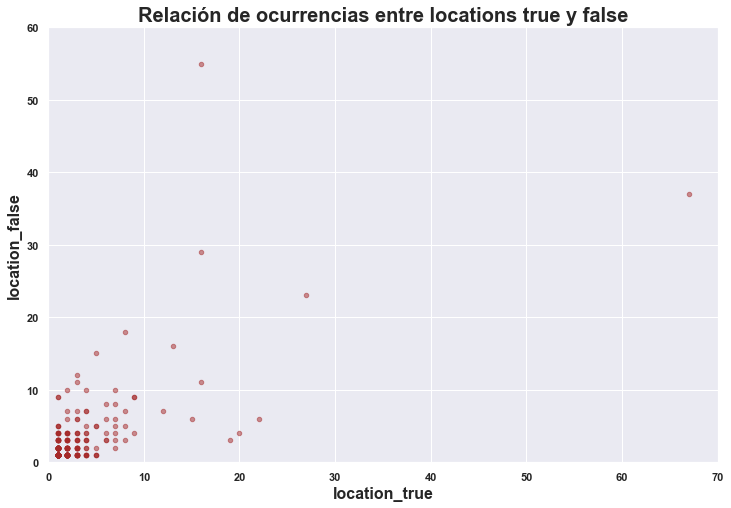

In [114]:
location_merge_mixtos.plot.scatter('#location_true','#location_false',c='Brown',title='Relación de ocurrencias entre locations true y false',alpha=0.5,figsize=(12,8))
ax=plt.gca()
plt.xlim(0, 70)
plt.ylim(0, 60)
plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.title('Relación de ocurrencias entre locations true y false', fontsize=20,weight='bold')
plt.ylabel('location_false', fontsize=16,weight='bold')
plt.xlabel('location_true', fontsize=16,weight='bold');

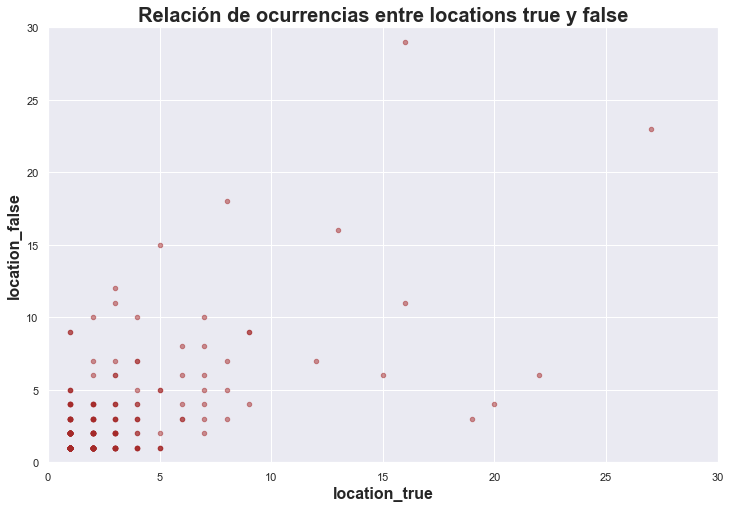

In [115]:
location_merge_mixtos.plot.scatter('#location_true','#location_false',c='Brown',title='Relación de ocurrencias entre locations true y false',alpha=0.5,figsize=(12,8))
ax=plt.gca()
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.title('Relación de ocurrencias entre locations true y false', fontsize=20,weight='bold')
plt.ylabel('location_false', fontsize=16,weight='bold')
plt.xlabel('location_true', fontsize=16,weight='bold');

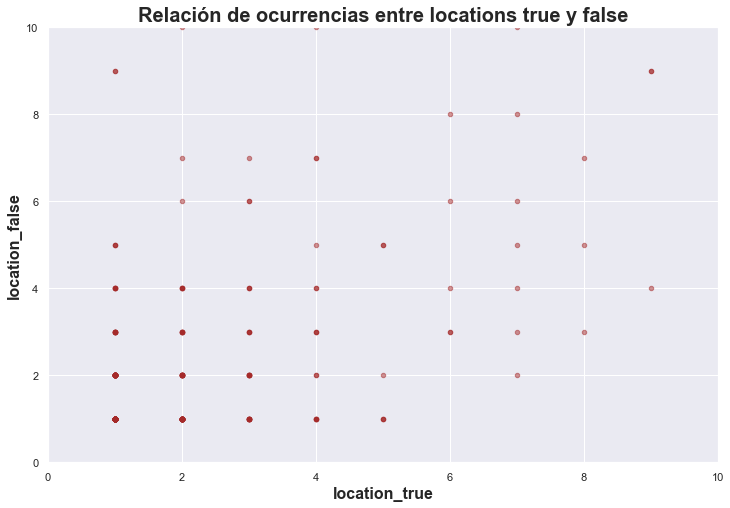

In [116]:
location_merge_mixtos.plot.scatter('#location_true','#location_false',c='Brown',title='Relación de ocurrencias entre locations true y false',alpha=0.5,figsize=(12,8))
ax=plt.gca()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Relación de ocurrencias entre locations true y false', fontsize=20,weight='bold')
plt.ylabel('location_false', fontsize=16,weight='bold')
plt.xlabel('location_true', fontsize=16,weight='bold');

Observamos que la relación entre las repeticiones es similar en ambos conjuntos, y que pocos casos se separan dandole más valor a las repeticiones de un conjunto en particular. Igualmente se pueden ponderar cada location según sus valores para ayudar a definir la veracidad de un tweet.